# Background removal with CountCorrect
In this notebook we show how to use CountCorrect to remove background from Nanostring WTA data

Load the required packages for this notebook and configure theano settings to use CountCorrect on gpu:

In [1]:
import sys,os
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import diffxpy.api as de
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
import countcorrect as cc

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


Load data from our NanostringWTA run:

In [2]:
adata_wta = pickle.load(open("data/nanostringWTA_fetailBrain_AnnData_geneProbes_smallExample.p", "rb" ))
adata_neg = pickle.load(open("data/nanostringWTA_fetailBrain_AnnData_negativeProbes_smallExample.p", "rb" ))

In this NanostringWTA run we profiled a 19pcw fetal brain case. We focussed on the cortex and arranged our ROIs to track neuronal differentiation trajectories from the ventricles on the inside to the cortical plate on the outside of the brain. We call this inside to outside dimension cortical depth. We used both large ROIs as shown in the image below:

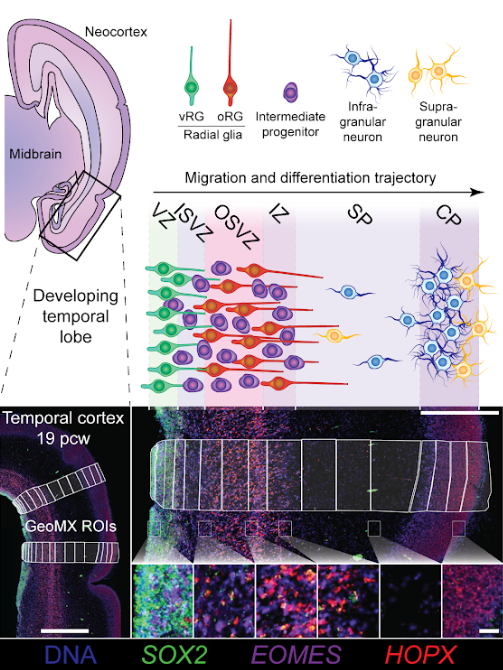

In [3]:
Image(filename='images/GeometricROIs.PNG')

As well as cell type specific areas of interest (AOIs) as shown in this image:

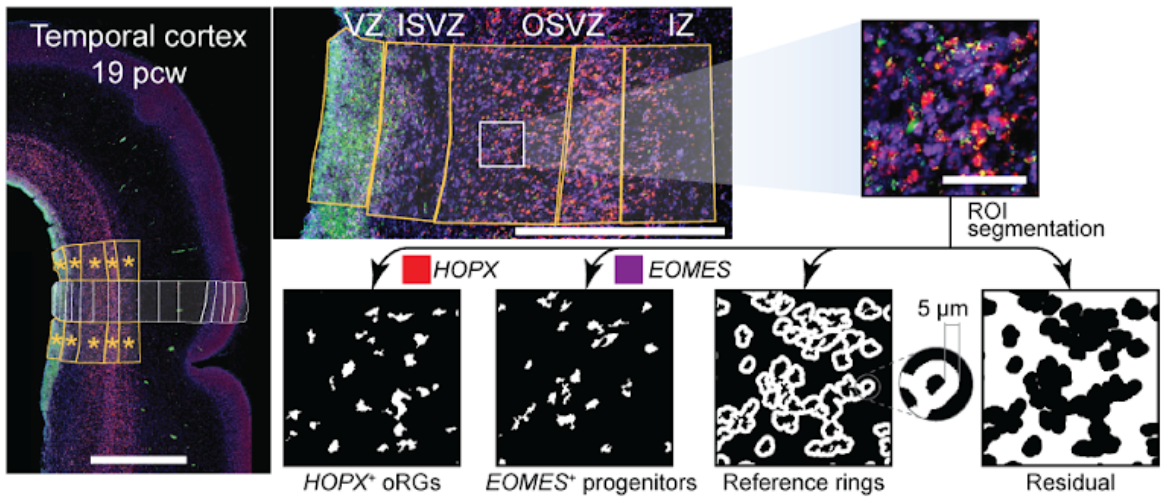

In [4]:
Image(filename='images/CellTypeSpecificAOIs.PNG')

We have already annotated ROIs/AOIs as good or low quality based on a read per nuclei count above 2000 and we do not use low quality ROIs/AOIs in the analysis here:

In [5]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

This histogram shows the range of nuclei counts we have in our ROIs/AOIs:

Text(0.5, 1.0, 'Number of Nuclei in ROIs')

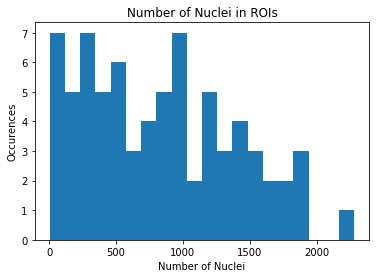

In [6]:
counts_nuclei = np.asarray(adata_wta.obs['nuclei']).reshape(len(adata_wta.obs['nuclei']),1)
plt.hist(counts_nuclei, bins = 20)
plt.xlabel('Number of Nuclei')
plt.ylabel('Occurences')
plt.title('Number of Nuclei in ROIs')

We took those ROIs at different positions across the temporal cortex (cortical depth), with a focus on the ventricular and subventricular zone at low cortical depth, where we also collected cell type specific areas of interest:

Text(0.5, 1.0, 'Number of ROIs at different Cortical Depth')

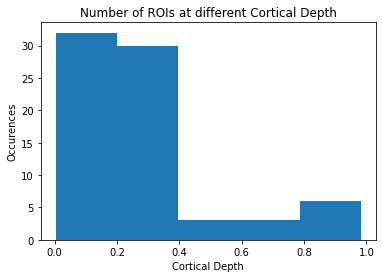

In [7]:
plt.hist(adata_wta.obs['VCDepth'], bins = 5)
plt.xlabel('Cortical Depth')
plt.ylabel('Occurences')
plt.title('Number of ROIs at different Cortical Depth')

The model needs seperate gene probes and negative probes in two numpy arrays. It also needs the nuclei counts. We initialize them here:

In [8]:
counts_geneProbes = np.asarray(adata_wta.X)
counts_negativeProbes = np.asarray(adata_neg.X)
counts_nuclei = np.asarray(adata_wta.obs['nuclei']).reshape(len(adata_wta.obs['nuclei']),1).squeeze()

We can now run CountCorrect:

Initializing model...
Fitting model ...


Average Loss = 5.5027e+06: 100%|██████████| 20000/20000 [07:45<00:00, 42.95it/s]
Finished [100%]: Average Loss = 5.5027e+06


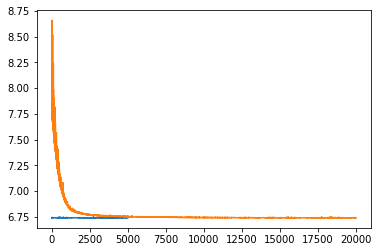

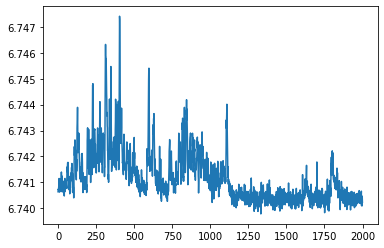

Sampling from posterior distribution...
Done.


In [9]:
X_corrected = cc.run_countcorrect(counts_geneProbes, counts_negativeProbes, counts_nuclei)

And add the corrected data to our AnnData object:

In [10]:
adata_wta.layers['X_corrected'] = X_corrected